In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('home_data.csv')

In [9]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [35]:
df = df.drop(['zipcode','lat','long'],axis=1)

Many factors describing a house, and they do not weight equally in determining a house price. So this experiment attempts to choose important features for finding a good model.

### Filter method: using Pearson Correlation

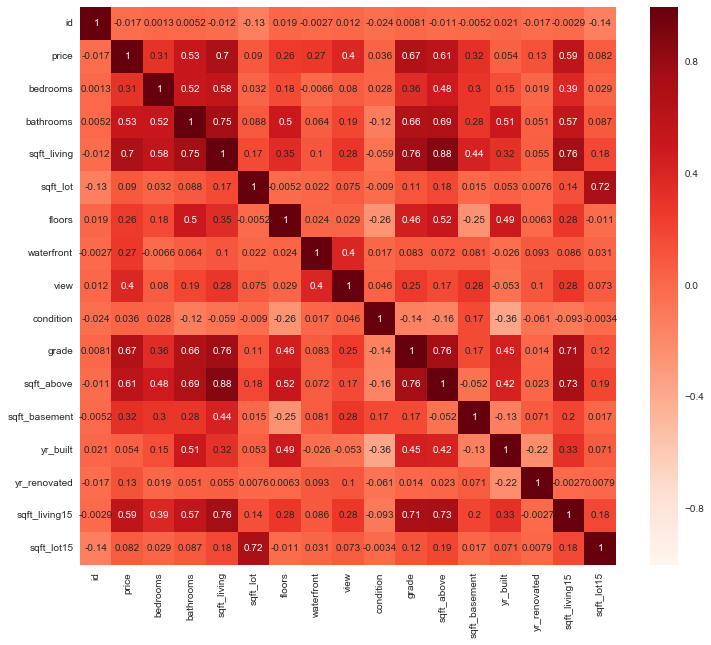

In [37]:
#since it is a continuous dataset, use Pearson correlation
plt.figure(figsize=(12,10))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

Dependent variable: price. So we will select features which are correlated with "price" with above 0.5. Meanwhile, the independent variables need to be uncorrelated with each other.

In [38]:
price_corr = corr['price']
relevant_f = price_corr[price_corr>0.5]
selected_features_list = list(relevant_f.index)[1:]
print (selected_features_list)

['bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15']


In [39]:
#it seems that all the suggested independent variables are highly correlated to each other.
df[selected_features_list].corr()

,bathrooms,sqft_living,grade,sqft_above,sqft_living15
bathrooms,1.000000,0.754665,0.664983,0.685342,0.568634
sqft_living,0.754665,1.000000,0.762704,0.876597,0.756420
grade,0.664983,0.762704,1.000000,0.755923,0.713202
sqft_above,0.685342,0.876597,0.755923,1.000000,0.731870
sqft_living15,0.568634,0.756420,0.713202,0.731870,1.000000


### Wrapper methods

In [40]:
import statsmodels.api as sm

In [78]:
all_features = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'sqft_living15', 'sqft_lot15']

### OLS

In [97]:
X = df[all_features].values
y = df['price'].values
columns_name = df[all_features].columns

In [90]:
X_1 = sm.add_constant(X)
model = sm.OLS(y, X_1).fit()
final_features = all_features.copy()
for i in range(1, len(model.pvalues)):
    if (model.pvalues[i] > 0.05):
        print (all_features[i-1], round(model.pvalues[i], 4))
        final_features.remove(all_features[i-1])    

sqft_lot 0.9751


"sqft_lot" has highest pvalue, and is greater than 0.05. We will remove this feature

### Embedded method - LASSO

In [91]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [102]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha: ", reg.alpha_)
print("Best score: ",reg.score(X,y))
coef = pd.Series(reg.coef_, index = columns_name)

Best alpha:  1363373.4068327625
Best score:  0.5213650585984257


/Users/yan/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [107]:
coef

bedrooms          -0.000000
bathrooms          0.000000
sqft_living      237.477500
sqft_lot           0.069075
floors             0.000000
waterfront         0.000000
view               0.000000
condition          0.000000
grade              0.000000
sqft_above        -0.000000
sqft_basement     15.312438
yr_built        -415.982113
yr_renovated      69.720072
sqft_living15     78.920893
sqft_lot15        -0.772509
dtype: float64

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [112]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### Find the importance of features by creating shadow features - random forests

In [119]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_std, y_train)

important_features = pd.DataFrame(model.feature_importances_, index=columns_name, columns=["importance"])
important_features.sort_values("importance", ascending=False)

/Users/yan/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,importance
sqft_lot,0.133126
sqft_lot15,0.128508
sqft_living15,0.124071
sqft_living,0.119073
sqft_above,0.117676
yr_built,0.115567
bathrooms,0.058850
sqft_basement,0.054950
bedrooms,0.040267
condition,0.035426


### Remove all low-variance features

In [123]:
from sklearn.feature_selection import VarianceThreshold, f_regression, SelectKBest
threshold = 0.90
vt = VarianceThreshold().fit(X_train_std)

vt_features = columns_name[vt.variances_ > threshold * (1-threshold)]
vt_features

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

### Recursive feature elimination - linear regression

In [124]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
model = LinearRegression()
rfe = RFE(model, 7)
rfe.fit(X_train_std, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
  n_features_to_select=7, step=1, verbose=0)

In [129]:
rfe_features_df = pd.DataFrame({'feature': columns_name, 'score': rfe.ranking_})
rfe_features_df.sort_values("score", ascending=False)[0:7]

,feature,score
12,yr_renovated,9
3,sqft_lot,8
7,condition,7
14,sqft_lot15,6
4,floors,5
13,sqft_living15,4
0,bedrooms,3


Summary: filter method is less accurate. The dataset does not contain many features, and without other important information, like location, it is a bit hard to improve the model's performance. Random forest method helped to explore important features for training.